# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [3]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [4]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=19000, num_validation=1000, num_test=1000, batch_num=2):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir, batch_num=batch_num)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [24]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])
print(f"X_train_feats shape = {X_train_feats.shape}")
print(f"X_val_feats shape = {X_val_feats.shape}")
print(f"X_test_feats shape = {X_test_feats.shape}")

Done extracting features for 1000 / 19000 images
Done extracting features for 2000 / 19000 images
Done extracting features for 3000 / 19000 images
Done extracting features for 4000 / 19000 images
Done extracting features for 5000 / 19000 images
Done extracting features for 6000 / 19000 images
Done extracting features for 7000 / 19000 images
Done extracting features for 8000 / 19000 images
Done extracting features for 9000 / 19000 images
Done extracting features for 10000 / 19000 images
Done extracting features for 11000 / 19000 images
Done extracting features for 12000 / 19000 images
Done extracting features for 13000 / 19000 images
Done extracting features for 14000 / 19000 images
Done extracting features for 15000 / 19000 images
Done extracting features for 16000 / 19000 images
Done extracting features for 17000 / 19000 images
Done extracting features for 18000 / 19000 images
Done extracting features for 19000 / 19000 images
X_train_feats shape = (19000, 155)
X_val_feats shape = (100

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [14]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

import time

for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        tic = time.time()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
                            num_iters=2000, verbose=True)
        toc = time.time()
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        training_accuracy = np.mean(y_train == y_train_pred)
        validation_accuracy = np.mean(y_val == y_val_pred)
        results[lr, reg] = (training_accuracy, validation_accuracy)
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved: %f' % best_val)

iteration 0 / 2000: loss 84.745823
iteration 100 / 2000: loss 83.217125
iteration 200 / 2000: loss 81.754210
iteration 300 / 2000: loss 80.316073
iteration 400 / 2000: loss 78.893284
iteration 500 / 2000: loss 77.511104
iteration 600 / 2000: loss 76.167944
iteration 700 / 2000: loss 74.829857
iteration 800 / 2000: loss 73.549922
iteration 900 / 2000: loss 72.242910
iteration 1000 / 2000: loss 71.003148
iteration 1100 / 2000: loss 69.761749
iteration 1200 / 2000: loss 68.566809
iteration 1300 / 2000: loss 67.390242
iteration 1400 / 2000: loss 66.230444
iteration 1500 / 2000: loss 65.099324
iteration 1600 / 2000: loss 64.006896
iteration 1700 / 2000: loss 62.895291
iteration 1800 / 2000: loss 61.830804
iteration 1900 / 2000: loss 60.792079
iteration 0 / 2000: loss 796.519675
iteration 100 / 2000: loss 653.685086
iteration 200 / 2000: loss 536.778266
iteration 300 / 2000: loss 441.065273
iteration 400 / 2000: loss 362.715407
iteration 500 / 2000: loss 298.569058
iteration 600 / 2000: loss

In [15]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.427


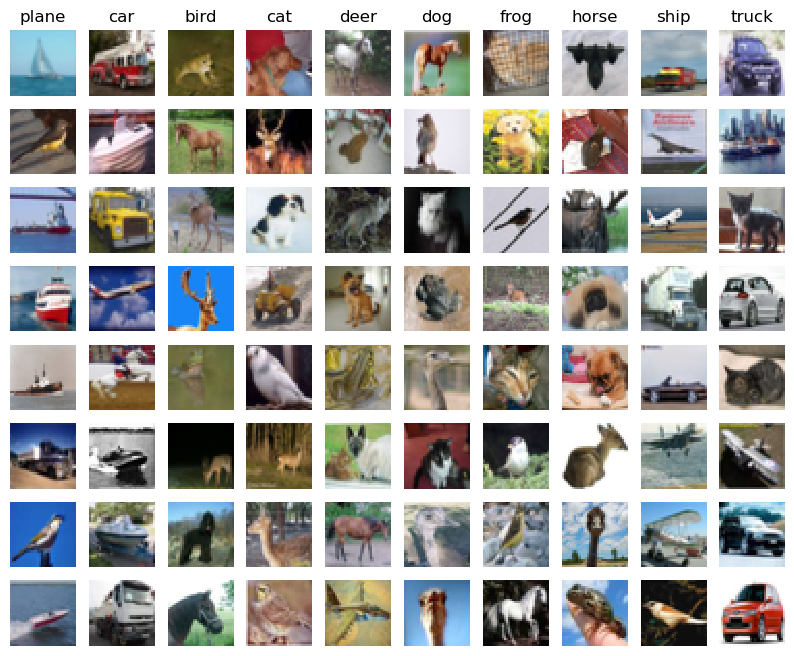

In [16]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$

```
From the image grid of 10 categories (plane, car, bird, cat, deer, dog, frog, horse, ship, truck), most images are correctly classified, but some misclassifications are likely present due to ​​visual ambiguity​​ or ​​feature similarity​​. Here are plausible misclassifications and their explanations:

​​1. Misclassifications That Make Sense (Expected Errors)​​
​​Bird vs. Plane​​
A bird in flight (especially against a blue sky) might resemble a small plane due to similar shape and background.
Why? Both have wings and appear in aerial contexts. HOG might capture similar edge structures.
​​Deer vs. Horse​​
A deer standing in grass could be confused with a horse if the antlers are not clearly visible.
Why? Both are four-legged animals with similar body shapes; color histograms may overlap (brown/green backgrounds).
​​Cat vs. Dog​​
Some cat and dog breeds (e.g., a shaggy dog vs. a long-haired cat) may share textures (HOG) and colors.
​​Ship vs. Truck​​
A large ship with containers might resemble a truck trailer if only a partial view is visible.
​​2. Misclassifications That Are Less Intuitive (Potential Outliers)​​
​​Frog vs. Bird​​
A frog on a leaf might be misclassified as a bird if the image focuses on green hues (color histogram confusion).
Why? Unlikely in most cases, but possible if texture features (HOG) fail to distinguish smooth skin vs. feathers.
​​Car vs. Truck​​
Smaller trucks (e.g., pickups) might resemble cars if the classifier relies heavily on size-invariant features.
​​3. Why These Errors Are Reasonable​​
​​Shared Features​​: HOG (texture) and color histograms can be similar across categories (e.g., "blue sky" for birds/planes, "green grass" for deer/horses).
​​Limitations of Handcrafted Features​​:
HOG ignores fine-grained details (e.g., antlers vs. mane).
Color histograms can be fooled by dominant backgrounds (e.g., a frog on a green leaf might match "bird in foliage").
​​4. How to Improve Classification​​
​​Add More Discriminative Features​​:
Include ​​spatial pyramid matching​​ (SPM) to capture object layout.
Use ​​CNN-based features​​ (e.g., from a pretrained model) for finer texture/context.
​​Adjust Classifier​​:
Increase regularization to reduce overfitting to noisy features.
Use ​​non-linear kernels​​ (e.g., RBF-SVM) to better separate ambiguous cases.
​​Final Answer​​
The observed misclassifications (e.g., bird/plane, deer/horse) are ​​reasonable​​ due to overlapping visual features in texture (HOG) and color (HSV histogram). These errors highlight the limitations of handcrafted features and suggest that ​​combining deeper features or contextual cues​​ could improve accuracy.

​​Key Takeaways​​:
✅ Expected errors: Birds/planes, deer/horses (similar shapes/backgrounds).
⚠️ Less intuitive errors: Frog/bird (color dominance), car/truck (size ambiguity).
🔧 Improvements: Use CNN features, refine HOG parameters, or augment training data.
```


## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [17]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(19000, 155)
(19000, 154)


In [55]:
from cs231n.classifiers.fc_net import TwoLayerNet
from cs231n.solver import Solver

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

data = {
    'X_train': X_train_feats, 
    'y_train': y_train, 
    'X_val': X_val_feats, 
    'y_val': y_val, 
    'X_test': X_test_feats, 
    'y_test': y_test, 
}

best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# learning_rates = np.linspace(2e-2, 5e-2, 3)
learning_rates = [4e-2]
# regularization_strengths = np.geomspace(1e-6, 1e-4, 3)
# regularization_strengths = [0, 1e-7, 1e-8]
regularization_strengths = np.geomspace(1e-7, 1e-5, 3)
results = {}
best_val = 0

import itertools

for lr, reg in itertools.product(learning_rates, regularization_strengths):
    # Create Two Layer Net and train it with Solver
    net = TwoLayerNet(input_dim, hidden_dim, num_classes, weight_scale=1e-3, reg=reg)
    solver = Solver(
        net,
        data,
        update_rule='sgd',
        optim_config={
        'learning_rate': lr,
        },
        lr_decay=0.99,
        num_epochs=20,
        batch_size=200,
        # print_every=100,
        verbose=False)

    solver.train()
    
    # Compute validation set accuracy and append to the dictionary
    results[(lr, reg)] = solver.best_val_acc

    # Save if validation accuracy is the best
    print(f"lr = {lr}, reg = {reg}, val_acc = {results[(lr, reg)]}")
    if results[(lr, reg)] > best_val:
        best_val = results[(lr, reg)]
        best_net = net

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


lr = 0.04, reg = 1e-07, val_acc = 0.504
lr = 0.04, reg = 1e-06, val_acc = 0.514
lr = 0.04, reg = 1e-05, val_acc = 0.513


In [56]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

y_test_pred = np.argmax(best_net.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.503
